# Sub-FOV Scan-phase

In [1]:
!uv pip install jupyterlab-vim

  TOML parse error at line 58, column 1
     |
  58 | [dependency-groups]
     | ^
  invalid table header
  duplicate key `dependency-groups` in document root

Using Python 3.12.4 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv
Audited 1 package in 11ms


In [2]:
import masknmf
from pathlib import Path
import fastplotlib as fpl
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

try:
    import mbo_utilities as mbo
except ImportError:
    print("uv pip install git+https://github.com/MillerBrainObservatory/mbo_utilities.git@dev")
    
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation

from mbo_utilities import log
from mbo_utilities.phasecorr import _phase_corr_2d

Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


## Collect all raw tiffs into a dictionary with: Plane: Data

In [4]:
raw_files = [x for x in Path(r"D:\tests_bigmem\roi2").glob("*.tif*")]
data_store = {}

for file in raw_files:
    if file.stem == "plane10":
        data_store[file.stem] = tifffile.memmap(file)
    
zplane_name = "plane10"
data = data_store[zplane_name]

In [ ]:
mdata = tifffile.TiffFile(file).shaped_metadata
mdata

In [5]:
def phase_offsets_timecourse(data, n_parts=3, upsample=10, max_offset=4, ):
    t, h, w = data.shape
    xsplits = np.linspace(0, w, n_parts + 1, dtype=int)
    offsets = []
    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        patch_offsets = [_phase_corr_2d(frame[:, x0:x1], upsample, max_offset=max_offset,) for frame in data]
        offsets.append(patch_offsets)
    return xsplits, np.array(offsets) 

def plot_phase_offsets(
    mean_img,
    xsplits,
    offsets,
    upsample,
    max_offset,
    title_prefix="",
    save_path=None,
    xmin=None,
    xmax=None,
    share_axis=True,
):
    n_parts, n_frames = offsets.shape
    all_y = np.concatenate(offsets)
    ymin, ymax = all_y.min(), all_y.max()
    pad = 0.05 * (ymax - ymin)
    ymin -= pad
    ymax += pad

    fig_height = 1.5 * (1 if share_axis else n_parts)
    fig = plt.figure(figsize=(10, fig_height), constrained_layout=True)
    outer = GridSpec(1, 2, width_ratios=[1.2, 2], wspace=0.2)

    ax_img = fig.add_subplot(outer[0, 0])
    ax_img.imshow(mean_img, cmap="gray")
    h, w = mean_img.shape
    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        center_x = (x0 + x1) / 2
        rect = plt.Rectangle((x0, 0), x1 - x0, h, edgecolor="red", facecolor="none", linewidth=1.5)
        ax_img.add_patch(rect)
        ax_img.text(center_x, h - 10, f"{i+1}", color='w', fontsize=12, weight="bold", ha="center", va="center")
    ax_img.axis("off")

    if share_axis:
        ax = fig.add_subplot(outer[0, 1])
        for i in range(n_parts):
            y = offsets[i]
            x = np.arange(len(y))
            ax.plot(x, y, lw=0.5, label=f"Part {i+1}")
        ax.axhspan(ymin, ymax, color="0.95", zorder=0)
        ax.set_ylim(ymin, ymax)
        if xmin is not None or xmax is not None:
            ax.set_xlim(left=xmin, right=xmax)
        ax.set_xlabel("Frame", fontsize=10)
        ax.set_ylabel("Offset (px)", fontsize=10)
        ax.spines[:].set_visible(False)
        # ax.tick_params(axis='both', which='both', direction='out')
        ax.legend(loc="best", fontsize=8, frameon=False)
        ax.text(
            0.98, 0.98,
            f"Y-axis: ±{ymax:.1f} px",
            transform=ax.transAxes,
            fontsize=9,
            ha="right",
            va="top",
            color="black",
            fontweight='bold'
        )
    else:
        inner = GridSpecFromSubplotSpec(n_parts, 1, subplot_spec=outer[0, 1], hspace=0.05)
        # label_text = f" Sub-FOVs share Y-axis scale: ± {ymax:.1f} px "
        label_text = ""
        for i in range(n_parts):
            ax = fig.add_subplot(inner[i])
            y = offsets[i]
            x = np.arange(len(y))
            ax.axhspan(ymin, ymax, color="0.95", zorder=0)
            ax.plot(x, y, color="black", lw=0.1, zorder=1)
            if xmin is not None or xmax is not None:
                ax.set_xlim(left=xmin, right=xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_ylabel(f"{i + 1}", fontsize=9, weight="bold", rotation=0, labelpad=15)
            ax.set_yticks([])
            ax.spines[:].set_visible(False)
            # ax.tick_params(axis='y', which='both', left=False, right=False)
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=(i == n_parts - 1))
            if i == 0:
                if label_text:
                    ax.text(
                        0.88, 1,
                        label_text,
                        transform=ax.transAxes,
                        fontsize=10,
                        ha="right",
                        va="top",
                        color="black",
                        fontweight='bold'
                    )
            if i == n_parts - 1:
                ax.set_xlabel("Frame", fontsize=10)

    if save_path:
        fig.savefig(save_path, dpi=150)

    fig.text(
        0.2, 0.94,
        f"{title_prefix}Per-Frame Offsets (1/{upsample}px) | max shift={max_offset}px",
        fontsize=14, ha="left", fontweight='bold'
    )
    plt.show()

def run_plot_for_plane(
    data,
    plane_name,
    save_dir=None,
    n_parts=None,
    upsample=None,
    max_offset=None,
    xmin=None,
    xmax=None,
    share_axis=False,
):
    mean_img = data.mean(0).astype(np.float32)
    xsplits, offsets = phase_offsets_timecourse(data, n_parts=n_parts, max_offset=max_offset, upsample=upsample,)
    if save_dir:
        Path(save_dir).mkdir(exist_ok=True)
        save_path = Path(save_dir) / f"{plane_name}_offset_plot.png"
    else:
        save_path = None
    plot_phase_offsets(
        mean_img,
        xsplits,
        offsets,
        upsample=upsample,
        max_offset=max_offset,
        title_prefix=f"{plane_name} | ",
        save_path=save_path,
        xmin=xmin, xmax=xmax,
        share_axis=True,
    )

In [6]:
max_offset = 4
n_parts = 4
upsample = 10

## Offsets for full FOV

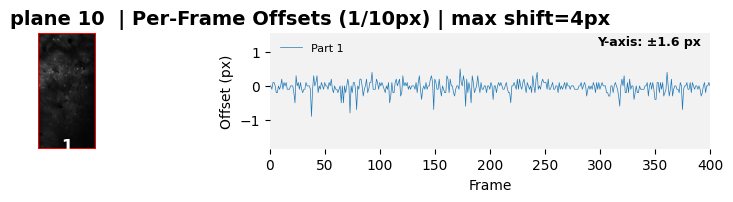

In [8]:
run_plot_for_plane(
    data_store["plane10"],
    "plane 10 ",
    save_dir="./results",
    n_parts=1,
    upsample=upsample,
    max_offset=max_offset,
    xmin=0,
    xmax=400,
    share_axis=True
)

In [9]:
# data = data_store['plane11']
# xsplits, offsets = phase_offsets_timecourse(data, n_parts=n_parts, max_offset=max_offset, upsample=upsample,)
max_offset = 4
xsplits_full, offsets_full = phase_offsets_timecourse(data, n_parts=1, max_offset=max_offset, upsample=upsample,)
xsplits, offsets = phase_offsets_timecourse(data, n_parts=4, max_offset=max_offset, upsample=upsample,)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_offsets_shared_axis(
    offsets,
    xsplits,
    upsample=10,
    max_offset=4,
    xmin=None,
    xmax=None,
    full_fov_offsets=None,
    title="Phase Offsets per Sub-FOV"
):
    n_parts, n_frames = offsets.shape
    x = np.arange(n_frames)

    all_y = offsets.ravel()
    ymin, ymax = all_y.min(), all_y.max()
    pad = 0.05 * (ymax - ymin)
    ymin -= pad
    ymax += pad

    fig, ax = plt.subplots(figsize=(10, 3))
    for i in range(n_parts):
        ax.plot(x, offsets[i], label=f"Part {i+1}", lw=0.5)

    if full_fov_offsets is not None:
        ax.plot(x, full_fov_offsets[0], "--", color="black", label="Full-FOV", lw=1.0, alpha=0.8)

    ax.axhspan(ymin, ymax, color="0.95", zorder=0)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin or 0, xmax or n_frames)
    ax.set_xlabel("Frame", fontsize=10)
    ax.set_ylabel("Offset (px)", fontsize=10)
    ax.spines[:].set_visible(False)
    ax.tick_params(direction='out')
    ax.legend(loc="upper right", fontsize=8, frameon=False)
    ax.set_title(f"{title} (1/{upsample}px) | max shift={max_offset}px", fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()
    
# plot_offsets_shared_axis(offsets, xsplits, upsample=10, max_offset=4, xmin=200, xmax=400, full_fov_offsets=offsets_full)


In [11]:
from mbo_utilities.phasecorr import apply_scan_phase_offsets

In [12]:
from scipy.ndimage import shift

def apply_phase_offsets_patched(data, xsplits, offsets):
    t, h, w = data.shape
    n_parts = len(xsplits) - 1
    offsets = np.asarray(offsets)  # shape: (n_parts, t)

    out = np.empty_like(data, dtype=np.float32)
    centers = xsplits[:-1] + np.diff(xsplits) // 2

    for frame_i in range(t):
        dx_parts = offsets[:, frame_i]
        x = np.arange(w)
        dx_map = np.interp(x, centers, dx_parts)

        for col in range(w):
            col_data = data[frame_i, :, col]
            shifted_col = shift(col_data, shift=0, order=1, mode="nearest", prefilter=False)
            shifted_col[1::2] = shift(col_data[1::2], shift=dx_map[col], order=1, mode="nearest", prefilter=False)
            out[frame_i, :, col] = shifted_col
    return out

In [13]:
corrected = apply_phase_offsets_patched(data, xsplits, offsets,)

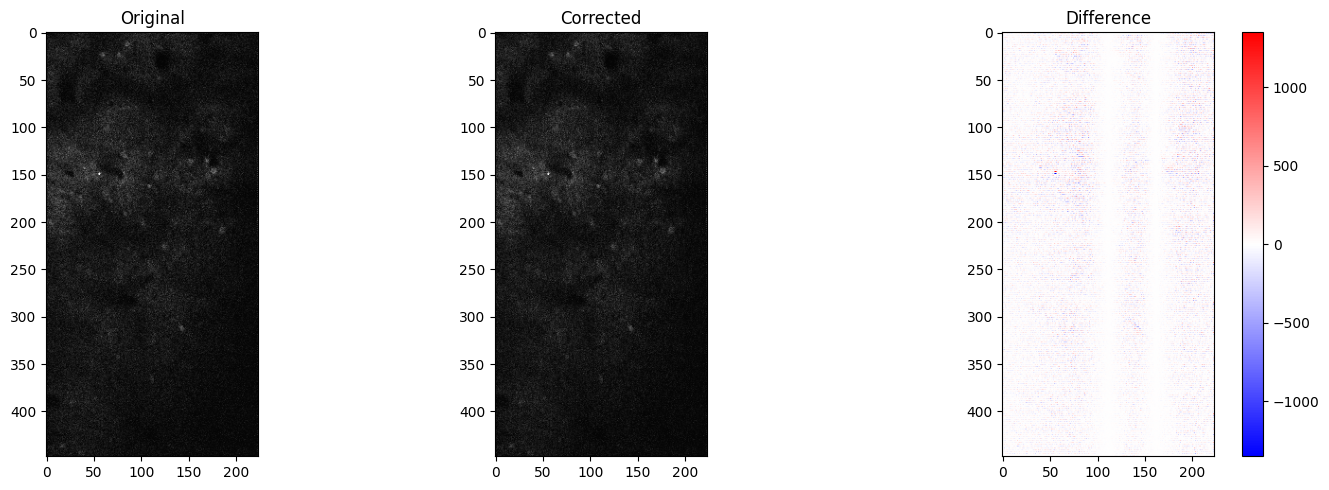

In [29]:
import matplotlib.pyplot as plt

frame_idx = 100  # pick a representative frame
before = data[frame_idx]
after = corrected[frame_idx]
diff = after - before

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(before, cmap="gray")
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(after, cmap="gray")
plt.title("Corrected")

plt.subplot(1, 3, 3)
plt.imshow(diff, cmap="bwr", vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.title("Difference")
plt.colorbar()
plt.tight_layout()
plt.show()


RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
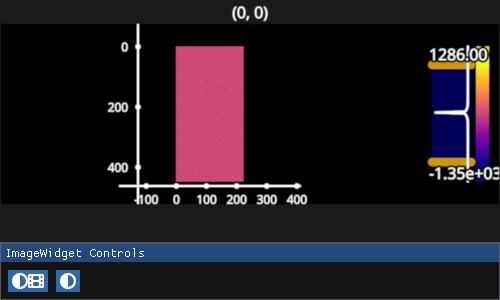

In [23]:
fpl.ImageWidget(diff).show()

In [49]:
xsplits.shape, offsets.shape

((5,), (4, 5632))

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
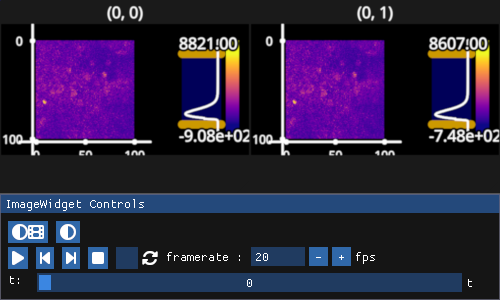

In [33]:
# xy = slice(10, 200)
xy = slice(100, 200)
iw = fpl.ImageWidget([data[:, xy, xy], corrected[:, xy, xy]])
iw.show()

In [34]:
iw.close()

In [35]:
def mean_row_misalignment(data):
    """Lower is better"""
    offsets = []
    for frame in data:
        even = frame[::2]
        odd = frame[1::2]
        m = min(len(even), len(odd))
        shift, _, _ = phase_cross_correlation(even[:m], odd[:m], upsample_factor=10)
        offsets.append(abs(shift[1]))  # X-axis
    return np.mean(offsets)

m1, m2 = mean_row_misalignment(data), mean_row_misalignment(corrected)

In [37]:
m1, m2

(np.float64(0.14000355113636365), np.float32(0.14758523))

In [38]:
m1, m2 = mean_row_misalignment(data[:, xy, xy]), mean_row_misalignment(corrected[:, xy, xy])

In [39]:
m1, m2

(np.float64(0.3008522727272727), np.float32(0.29962713))

In [41]:
def temporal_corr(data, x0, x1, y0, y1):
    patch = data[:, y0:y1, x0:x1]
    t = patch.shape[0]
    corrs = [np.corrcoef(patch[i].ravel(), patch[i+1].ravel())[0, 1] for i in range(t - 1)]
    return np.nanmean(corrs)

temporal_corr(data, 100, 200, 100, 200), temporal_corr(corrected, 100, 200, 100, 200)

(np.float64(0.3866461297792846), np.float64(0.4120921984734401))

In [42]:
import numpy as np
from scipy.ndimage import sobel

def sharpness_metric(frame):
    gx = sobel(frame, axis=0)
    gy = sobel(frame, axis=1)
    return np.mean(np.sqrt(gx**2 + gy**2))

def avg_sharpness(data):
    return np.mean([sharpness_metric(f) for f in data])

In [44]:
avg_sharpness(data), avg_sharpness(corrected)

(np.float32(nan), np.float32(1834.4777))

In [45]:
def snr_roi(data, y0, y1, x0, x1):
    """Higher = Better"""
    roi = data[:, y0:y1, x0:x1]
    mean_signal = np.mean(roi)
    noise = np.std(roi)
    return mean_signal / noise

snr_roi(data, 100, 200, 100, 200), snr_roi(corrected, 100, 200, 100, 200)

(np.float64(1.3716563990124973), np.float32(1.4411372))

In [24]:
zplane_name = "plane10"
data = data_store[zplane_name]
xsplits_full, offsets_full = phase_offsets_timecourse(data, n_parts=4, max_offset=max_offset, upsample=upsample,)

In [57]:
tifffile.imwrite(r"D:\tests\\plane10_interp_4strips.tif", corrected)